In [1]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras import metrics
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
mat = scipy.io.loadmat('Desktop/wiki_crop/wiki.mat')

In [16]:
instances = mat['wiki'][0][0][0].shape[1]
 
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]
 
df = pd.DataFrame(index = range(0,instances), columns = columns)
 
for i in mat:
  if i == "wiki":
    current_array = mat[i][0][0]
    for j in range(len(current_array)):
      df[columns[j]] = pd.DataFrame(current_array[j][0])

In [17]:
#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

#some records do not have a gender information
df = df[~df['gender'].isna()]

In [18]:
df = df.drop(columns = ['dob','photo_taken','name','face_score','second_face_score','face_location'])

In [19]:
df.head()

,full_path,gender
0,[17/10000217_1981-05-05_2009.jpg],1.0
2,[12/100012_1948-07-03_2008.jpg],1.0
4,[16/10002116_1971-05-31_2012.jpg],0.0
5,[02/10002702_1960-11-09_2012.jpg],0.0
6,[41/10003541_1937-09-27_1971.jpg],1.0


In [20]:
print(df['gender'].value_counts().sort_index())

classes = 2 #male, female
print("number of output classes: ",classes)

0.0     6580
1.0    15575
Name: gender, dtype: int64
number of output classes:  2


In [21]:
target_size = (224, 224)

def getImagePixels(image_path):
    img = image.load_img("Desktop/wiki_crop/%s" % image_path[0], grayscale=False, target_size=target_size)
    x = image.img_to_array(img).reshape(1, -1)[0]
    #x = preprocess_input(x)
    return x

In [23]:
df = df[:15000]
df.shape

(15000, 2)

In [24]:
df['pixels'] = df['full_path'].apply(getImagePixels)

In [25]:
df.head() 

,full_path,gender,pixels
0,[17/10000217_1981-05-05_2009.jpg],1.0,"[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 255..."
2,[12/100012_1948-07-03_2008.jpg],1.0,"[92.0, 97.0, 91.0, 89.0, 94.0, 90.0, 91.0, 96...."
4,[16/10002116_1971-05-31_2012.jpg],0.0,"[61.0, 30.0, 10.0, 61.0, 30.0, 10.0, 61.0, 30...."
5,[02/10002702_1960-11-09_2012.jpg],0.0,"[97.0, 122.0, 178.0, 97.0, 122.0, 178.0, 97.0,..."
6,[41/10003541_1937-09-27_1971.jpg],1.0,"[190.0, 189.0, 194.0, 204.0, 203.0, 208.0, 203..."


In [26]:
target = df['gender'].values
target_classes = keras.utils.to_categorical(target, classes)

In [27]:
features = []
for i in range(0, df.shape[0]):
    features.append(df['pixels'].values[i])
    
features = np.array(features)
features = features.reshape(features.shape[0], 224,224,3)

In [28]:
features.shape

(15000, 224, 224, 3)

In [29]:
features /= 255.

In [30]:
train_X, test_X, train_Y, test_Y = train_test_split(features, target_classes, test_size = 0.3)
print('Training set: ', train_X.shape, train_Y.shape)
print('Test set: ', test_X.shape, test_Y.shape)

Training set:  (10500, 224, 224, 3) (10500, 2)
Test set:  (4500, 224, 224, 3) (4500, 2)


In [31]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

W0806 13:30:22.704485 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 13:30:22.861598 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 13:30:23.102778 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 13:30:23.257338 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is d

In [32]:
model.load_weights('Desktop/gender_detection/vgg_face_weights.h5')

W0806 13:30:27.143194 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



In [33]:
for layer in model.layers[:-7]:
    layer.trainable = False
    
base_model_output = Sequential()
base_model_output = Convolution2D(classes, (1,1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs = model.input, outputs = base_model_output)

In [34]:
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
        
    print('--------------------------')
    for layer in gender_model.layers:
        print(layer, layer.trainable)

In [35]:
#sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='binary_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  , metrics=['accuracy']
                 )

W0806 13:30:36.824186 140735514583872 deprecation_wrapper.py:119] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 13:30:36.853646 140735514583872 deprecation.py:323] From /Users/jadele/anaconda2/envs/vir_env/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [36]:
checkpointer = ModelCheckpoint(filepath = 'classification_gender_model.hdf5',
                              monitor = 'val_loss',
                              verbose = 1,
                              save_best_only = True,
                              mode = 'auto')


In [37]:
scores = []

enableFit = False

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_X.shape[0], size=batch_size)
        
        score = gender_model.fit(
            train_X[ix_train], train_Y[ix_train]
            , epochs=1
            , validation_data=(test_X, test_Y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
        
        from keras.models import load_model
        gender_model = load_model("classification_gender_model.hdf5")
        
        gender_model.save_weights('gender_model_weights.h5')
        
else:
    #pre-trained weights for gender prediction: https://drive.google.com/file/d/1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk/view?usp=sharing
    gender_model.load_weights("Desktop/gender_detection/gender_model_weights.h5")

In [39]:
gender_model.evaluate(test_X, test_Y, verbose = 1)

4500/4500 [==============================] - 1195s 266ms/step


[0.048036506596538756, 0.9862222222222222]

In [40]:
predictions = gender_model.predict(test_X)

In [41]:
from sklearn.metrics import classification_report, confusion_matrix

pred_list = []
actual_list = []

for i in predictions:
    pred_list.append(np.argmax(i))
    
for i in test_Y:
    actual_list.append(np.argmax(i))

confusion_matrix(actual_list, pred_list)

array([[1313,   32],
       [  30, 3125]])

In [42]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224,224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img /= 255.
    return test_img

In [44]:
pic1 = 'Desktop/test_images/s.png'

prediction = gender_model.predict(loadImage(pic1))

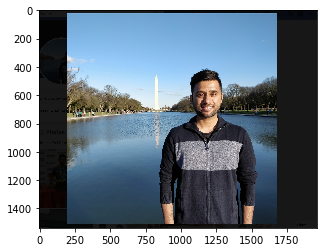

gender:  Male


In [45]:
img = image.load_img(pic1)
plt.imshow(img)
plt.show()

gender='Male' if np.argmax(prediction) == 1 else 'Female'
print('gender: ', gender)

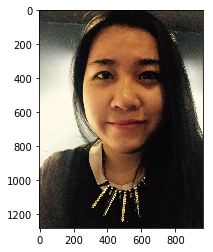

gender:  Female


In [58]:
pic3 = 'Desktop/test_images/IMG_0233.jpg'
prediction = gender_model.predict(loadImage(pic3))


img = image.load_img(pic3)
plt.imshow(img)
plt.show()

gender = 'Male' if np.argmax(prediction) == 1 else 'Female'
print('gender: ', gender)

In [55]:
df['gender'].value_counts().sort_index()
#0: woman, 1: man

0.0     4420
1.0    10580
Name: gender, dtype: int64

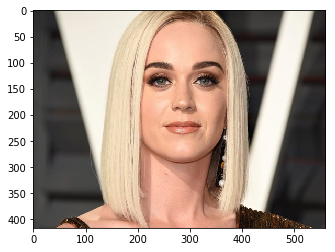

gender:  Female


In [57]:
pic4 = 'Desktop/test_images/katy.jpg'
prediction = gender_model.predict(loadImage(pic4))


img = image.load_img(pic4)
plt.imshow(img)
plt.show()

gender = 'Male' if np.argmax(prediction) == 1 else 'Female'
print('gender: ', gender)